# ⚡ Electricity Price Volatility Analysis (France - EPEX Spot)
This notebook performs descriptive and volatility analysis of hourly electricity prices from the French Day-Ahead Market (EPEX Spot) on 08 April 2025.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")

In [44]:
df = pd.read_csv("epex_france_apr06-08_hourly.csv")
df.head()

,Date,Hour,Price (€/MWh)
0,2025-04-06,00-01,70.45
1,2025-04-06,01-02,46.21
2,2025-04-06,02-03,35.01
3,2025-04-06,03-04,27.01
4,2025-04-06,04-05,25.50


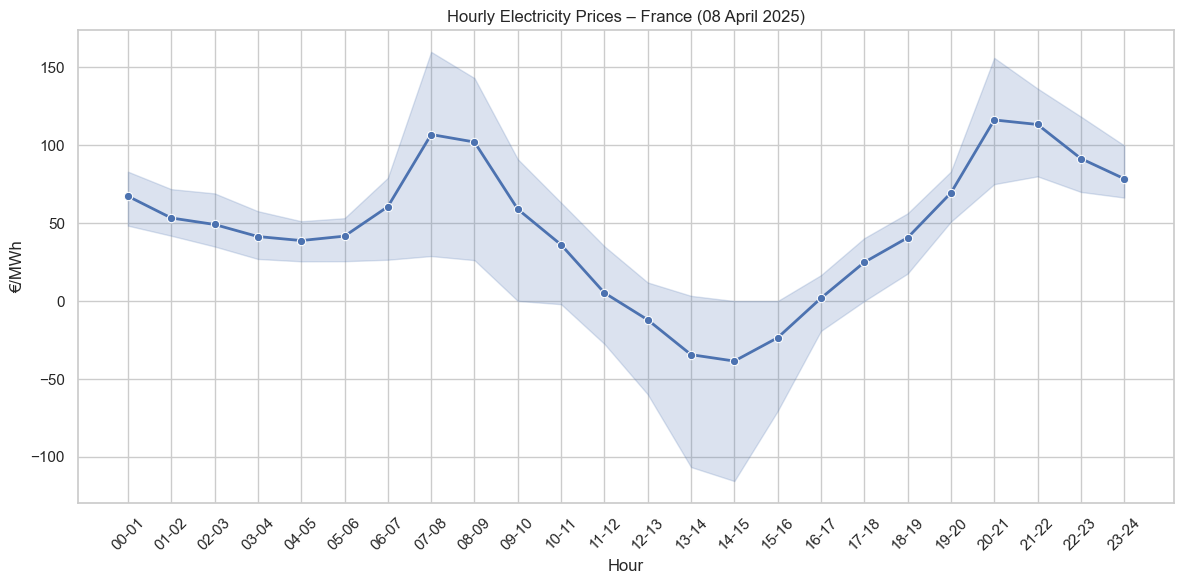

In [45]:
# Plot hourly prices
plt.figure(figsize=(12,6))
sns.lineplot(x='Hour', y='Price (€/MWh)', data=df, marker="o", linewidth=2)
plt.title("Hourly Electricity Prices – France (08 April 2025)")
plt.xticks(rotation=45)
plt.ylabel("€/MWh")
plt.xlabel("Hour")
plt.tight_layout()
plt.show()

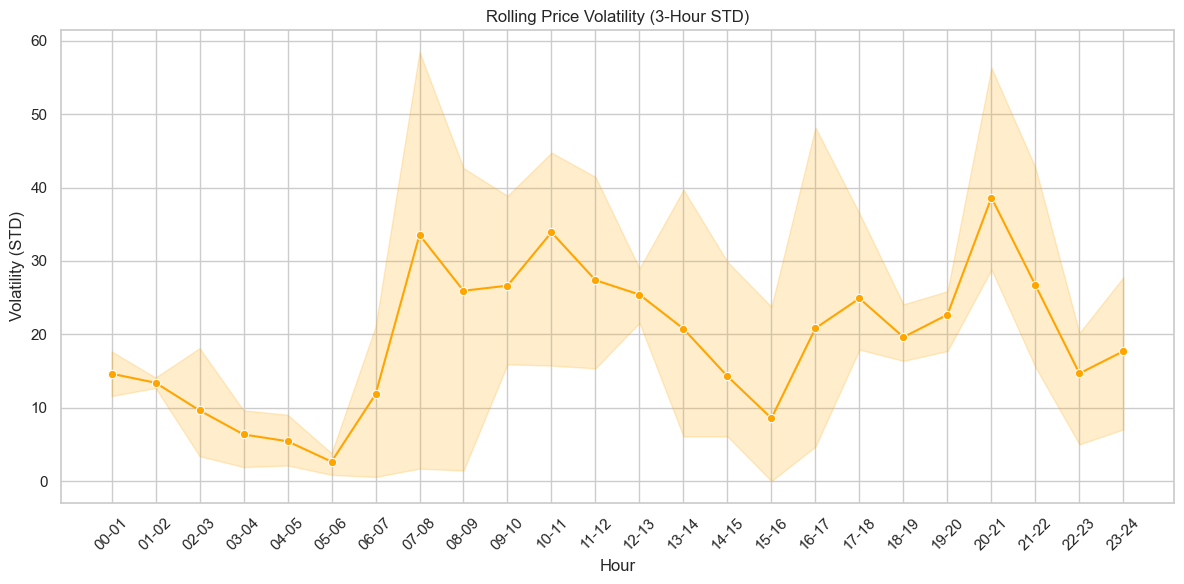

In [46]:
# Rolling Volatility (3-hour window)
df['Rolling_STD'] = df['Price (€/MWh)'].rolling(window=3).std()
plt.figure(figsize=(12,6))
sns.lineplot(x='Hour', y='Rolling_STD', data=df, marker="o", color='orange')
plt.title("Rolling Price Volatility (3-Hour STD)")
plt.xticks(rotation=45)
plt.ylabel("Volatility (STD)")
plt.xlabel("Hour")
plt.tight_layout()
plt.show()

In [47]:
# ⚠️ Z-score Risk Detection
from scipy.stats import zscore
df['Z_Score'] = zscore(df['Price (€/MWh)'])
df[['Hour', 'Price (€/MWh)', 'Z_Score']].sort_values(by='Z_Score', ascending=False).head()

,Hour,Price (€/MWh),Z_Score
31,07-08,159.86,2.137689
44,20-21,156.00,2.065612
32,08-09,143.04,1.823613
56,08-09,136.77,1.706535
45,21-22,136.34,1.698506


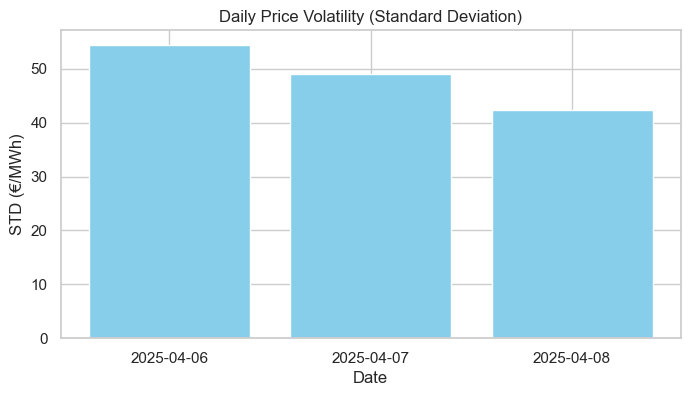

In [48]:
# The daily standard deviation of electricity prices (a measure of daily volatility)
daily_volatility = df.groupby("Date")["Price (€/MWh)"].std().reset_index()
daily_volatility.columns = ["Date", "Daily Volatility (STD)"]

# Daily Volatility
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(daily_volatility["Date"], daily_volatility["Daily Volatility (STD)"], color="skyblue")
plt.title("Daily Price Volatility (Standard Deviation)")
plt.ylabel("STD (€/MWh)")
plt.xlabel("Date")
plt.show()

In [49]:
# splice to timestamp
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Hour"].str[:2] + ":00")

# set index
df = df.set_index("Datetime").sort_index()

# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df["Price (€/MWh)"], order=(2,1,1))
model_fit = model.fit()

# predict the next 24 hours
forecast = model_fit.forecast(steps=24)
print("24-hour forecast:")
print(forecast)


24-hour forecast:
2025-04-09 00:00:00    70.083568
2025-04-09 01:00:00    72.907613
2025-04-09 02:00:00    73.828413
2025-04-09 03:00:00    73.748269
2025-04-09 04:00:00    73.580710
2025-04-09 05:00:00    73.530401
2025-04-09 06:00:00    73.536764
2025-04-09 07:00:00    73.546657
2025-04-09 08:00:00    73.549383
2025-04-09 09:00:00    73.548917
2025-04-09 10:00:00    73.548335
2025-04-09 11:00:00    73.548189
2025-04-09 12:00:00    73.548222
2025-04-09 13:00:00    73.548255
2025-04-09 14:00:00    73.548263
2025-04-09 15:00:00    73.548261
2025-04-09 16:00:00    73.548259
2025-04-09 17:00:00    73.548259
2025-04-09 18:00:00    73.548259
2025-04-09 19:00:00    73.548259
2025-04-09 20:00:00    73.548259
2025-04-09 21:00:00    73.548259
2025-04-09 22:00:00    73.548259
2025-04-09 23:00:00    73.548259
Freq: h, Name: predicted_mean, dtype: float64


/Users/kwor/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/kwor/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/kwor/myenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [50]:
# export file for power bi
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Hour"].str[:2] + ":00")
df.to_csv("powerbi_future_24.csv", index=False)
print("Exported CSV for Power BI.")


Exported CSV for Power BI.
